# Installs

In [72]:
!pip install torchinfo --quiet

# Imports

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm

In [74]:
input_path="/kaggle/input/ethiopia-earthquake-data/earthquake_data.csv"
df = pd.read_csv(input_path)
df = df.fillna(0) 
df.head()

,timestamp,latitude,longitude,depth,magnitude,year,month,day,hour,day_of_week,season,previous_quake,seismic_activity,b_value
0,2025-03-03 04:37:39,14.0119,40.0375,8.3,4.5,2025,3,3,4,0,belg,0.0,0,0.136714
1,2025-03-02 20:38:47,14.1521,39.7806,10.0,4.1,2025,3,2,20,6,belg,-28732.0,1,0.136714
2,2025-03-02 15:11:20,14.0665,39.8348,10.0,4.3,2025,3,2,15,6,belg,-19647.0,1,0.136714
3,2025-03-02 08:14:58,14.2209,39.8918,10.0,5.2,2025,3,2,8,6,belg,-24982.0,1,0.136714
4,2025-02-27 08:27:47,9.1703,40.2964,10.0,4.7,2025,2,27,8,3,belg,-258431.0,1,0.136714


In [75]:
season_mapping={"bega":0, "belg":1,"kiremt":2}
df['season']=df['season'].map(season_mapping)

In [76]:
# Convert the 'timestamp' column to datetime y
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Convert to Unix timestamp
df['timestamp'] = df['timestamp'].astype(int) // 10**9  # Convert to seconds

In [77]:
# Get a detailed summary of the DataFrame
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10180 entries, 0 to 10179
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         10180 non-null  int64  
 1   latitude          10180 non-null  float64
 2   longitude         10180 non-null  float64
 3   depth             10180 non-null  float64
 4   magnitude         10180 non-null  float64
 5   year              10180 non-null  int64  
 6   month             10180 non-null  int64  
 7   day               10180 non-null  int64  
 8   hour              10180 non-null  int64  
 9   day_of_week       10180 non-null  int64  
 10  season            10180 non-null  int64  
 11  previous_quake    10180 non-null  float64
 12  seismic_activity  10180 non-null  int64  
 13  b_value           10180 non-null  float64
dtypes: float64(6), int64(8)
memory usage: 1.1 MB
None


In [78]:
df.set_index('timestamp', inplace=True)

In [79]:
# Normalize features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = ['latitude', 'longitude', 'depth', 'magnitude','year','month','day','hour','day_of_week','season','previous_quake', 'seismic_activity', 'b_value']
df[features] = scaler.fit_transform(df[features])

In [80]:
# Prepare sequences
def create_sequences(data, step_size=1, output_seq=3):
    sequences, targets = [], []
    for i in range(len(data) - step_size - output_seq):
        sequences.append(data[i:i+step_size].values)
        targets.append(data[i+step_size:i+step_size+output_seq]['magnitude'].values)
    return np.array(sequences), np.array(targets)


In [81]:
step_size = 32  # Number of time steps
output_seq = 3  # Predict next 3 points
X, y = create_sequences(df, step_size, output_seq)

In [82]:
# Split into train-test
train_size = int(0.8 * len(X))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [83]:
# PyTorch Dataset
class EarthquakeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [84]:
batch_size = 32
dataset_train = EarthquakeDataset(X_train, y_train)
dataset_test = EarthquakeDataset(X_test, y_test)
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [85]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=8, num_layers=6, output_seq=3):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.rand(1, step_size, d_model))
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, output_seq)
    
    def forward(self, src):
        _input= self.input_layer(src)
        src = _input+ self.positional_encoding
        memory = self.encoder(src)
        # print("yes")
        out = self.decoder(memory, memory)
        return self.output_layer(out[:, -1, :])


In [101]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=512, nhead=8, num_layers=,24 output_seq=3, ff_dim=2048, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Input embedding
        self.input_layer = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.positional_encoding = self.create_positional_encoding(d_model, 5000)  # Fixed size for now
        
        # Transformer layers
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=ff_dim, dropout=dropout)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=ff_dim, dropout=dropout)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)
        
        # Output layer
        self.output_layer = nn.Linear(d_model, output_seq)
        
    def create_positional_encoding(self, d_model, max_len=5000):
        """Generates positional encoding for better sequence understanding."""
        pos = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        return pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, src):
        src = self.input_layer(src)
        src = src + self.positional_encoding[:, :src.size(1), :].to(src.device)  # Apply positional encoding
        
        memory = self.encoder(src)
        out = self.decoder(memory, memory)
        
        return self.output_layer(out[:, -1, :])  # Predict the last token

# Example usage:
# model = TransformerModel(input_dim=128)
# print(model)

SyntaxError: invalid syntax (<ipython-input-101-bccee44328cb>, line 2)

In [102]:
# Initialize model
input_dim = len(features)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_dim).to(DEVICE)
# summary(model, input_size=(step_size, input_dim))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [103]:
# Loss, Optimizer, Scheduler
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [104]:
# Training
epochs = 20
def train_model(model, train_loader):
    model.train()
    for epoch in tqdm(range(epochs)):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")

train_model(model, train_loader)

  5%|▌         | 1/20 [00:59<18:44, 59.17s/it]

Epoch 1, Loss: 0.22215030409806358


 10%|█         | 2/20 [01:57<17:32, 58.48s/it]

Epoch 2, Loss: 0.019736930841624034


 15%|█▌        | 3/20 [02:55<16:31, 58.32s/it]

Epoch 3, Loss: 0.013154837187364932


 20%|██        | 4/20 [03:53<15:33, 58.34s/it]

Epoch 4, Loss: 0.011721781830809365


 25%|██▌       | 5/20 [04:51<14:34, 58.28s/it]

Epoch 5, Loss: 0.01089912481554674


 30%|███       | 6/20 [05:49<13:35, 58.22s/it]

Epoch 6, Loss: 0.01098454324528575


 35%|███▌      | 7/20 [06:48<12:36, 58.21s/it]

Epoch 7, Loss: 0.01081949380395098


 40%|████      | 8/20 [07:46<11:39, 58.26s/it]

Epoch 8, Loss: 0.010464143270157336


 45%|████▌     | 9/20 [08:44<10:41, 58.28s/it]

Epoch 9, Loss: 0.010760384527453053


 50%|█████     | 10/20 [09:43<09:42, 58.26s/it]

Epoch 10, Loss: 0.010565226629933738


 55%|█████▌    | 11/20 [10:41<08:43, 58.21s/it]

Epoch 11, Loss: 0.009846611557103048


 60%|██████    | 12/20 [11:39<07:45, 58.15s/it]

Epoch 12, Loss: 0.009829225640113312


 65%|██████▌   | 13/20 [12:37<06:47, 58.16s/it]

Epoch 13, Loss: 0.009807072083033093


 70%|███████   | 14/20 [13:35<05:49, 58.19s/it]

Epoch 14, Loss: 0.009816853881366258


 75%|███████▌  | 15/20 [14:33<04:51, 58.24s/it]

Epoch 15, Loss: 0.00981233763603831


 80%|████████  | 16/20 [15:32<03:53, 58.27s/it]

Epoch 16, Loss: 0.009867305889373689


 85%|████████▌ | 17/20 [16:30<02:54, 58.24s/it]

Epoch 17, Loss: 0.009796850542779866


 90%|█████████ | 18/20 [17:28<01:56, 58.20s/it]

Epoch 18, Loss: 0.00984467144718203


 95%|█████████▌| 19/20 [18:26<00:58, 58.21s/it]

Epoch 19, Loss: 0.009830865083174326


100%|██████████| 20/20 [19:25<00:00, 58.25s/it]

Epoch 20, Loss: 0.009831964628638949


In [105]:
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
            output = model(X_batch)
            predictions.append(output.cpu().numpy())
            actuals.append(y_batch.cpu().numpy())
    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}")

evaluate_model(model, test_loader)

MAE: 0.14350444078445435, MSE: 0.027215123176574707, RMSE: 0.16497007012367249, MAPE: 24.502670764923096


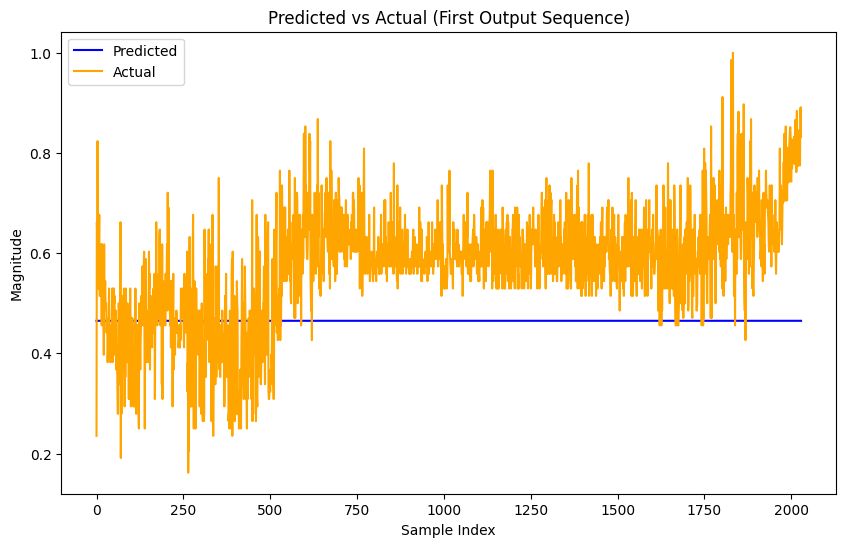

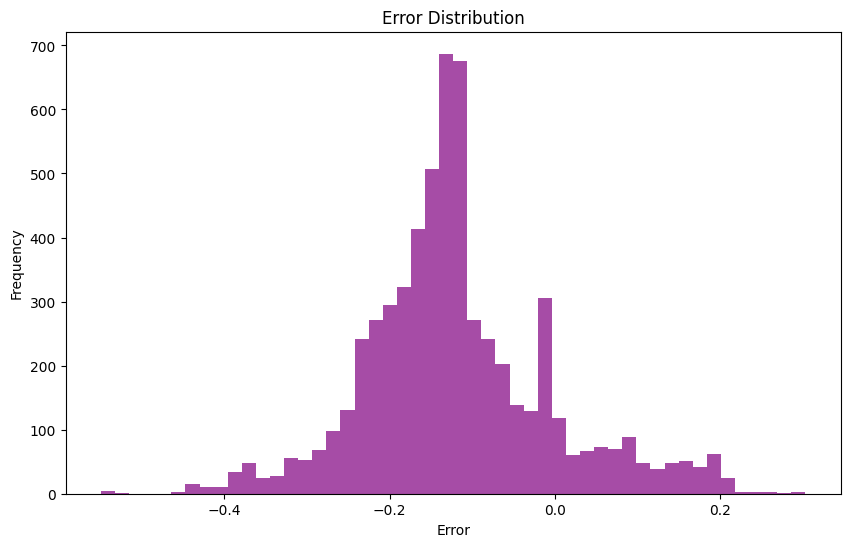

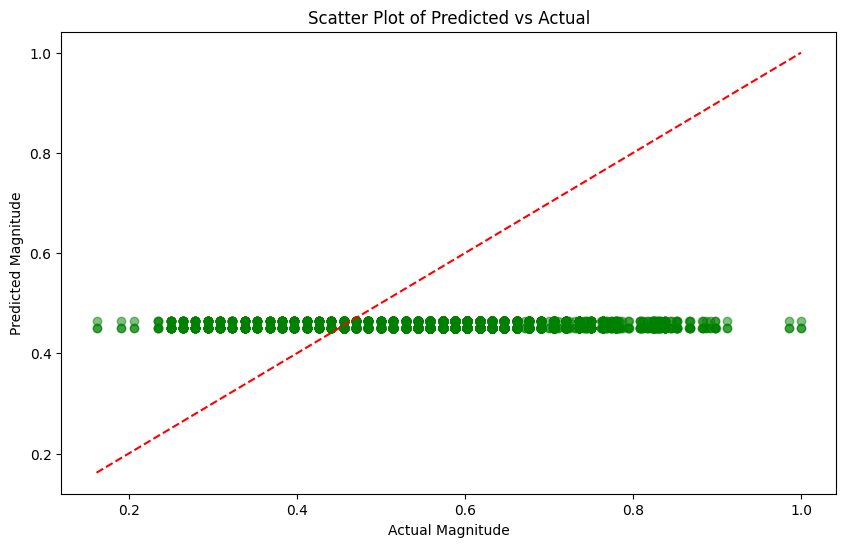

In [106]:
# Visualize Predictions vs Actuals
predictions, actuals = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        output = model(X_batch)
        predictions.append(output.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Plot Predicted vs Actual for the first output sequence
plt.figure(figsize=(10, 6))
plt.plot(predictions[:, 0], label='Predicted', color='blue')
plt.plot(actuals[:, 0], label='Actual', color='orange')
plt.title('Predicted vs Actual (First Output Sequence)')
plt.xlabel('Sample Index')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

# Plot error distribution
errors = predictions - actuals
plt.figure(figsize=(10, 6))
plt.hist(errors.flatten(), bins=50, color='purple', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

# Scatter plot of Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(actuals.flatten(), predictions.flatten(), alpha=0.5, color='green')
plt.title('Scatter Plot of Predicted vs Actual')
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.plot([actuals.min(), actuals.max()], [actuals.min(), actuals.max()], color='red', linestyle='--')
plt.show()